# Clustering Credit Card Users

In this notebook, our main task is to cluster credit card users into different groups and see if we can find any meaning patterns. We will use Principal Component Analysis (PCA) to reduce the dimension of the feature space and then use the K means algorithm to find clusters.

## Data set Description

The Data set summaraizes the usage behavior of about 9000 active credit cards holders during the last 6 months. The file is at a customer level with 18 behavioral variables.

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, normalize
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

Task: Cluster the credit card users into diﬀerent groups to find any meaningful patterns. Use
Principal Component Analysis (PCA) to reduce the dimension of the feature space and then
use the K-means algorithm to find clusters. Import relevant Python libraries.

## Load dataset (CC GENERAL.csv, the name of the file when downloaded from Kaggle.)

In [19]:
ccData = pd.read_csv('CC GENERAL.csv')
print('Rows:', ccData.shape[0]) 
print('Columns:', ccData.shape[1])
ccData.head()

Rows: 8950
Columns: 18


,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,C10001,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,C10002,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,C10003,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
4,C10005,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


## First look

There are 8950 rows and 18 attributes in each row. Since this is an unsupervised learning problem, we do not have a response variable. Moreover, not that CUST_ID can be removed as its sole peurpose is to be a primary key.

After import attributes have been identified through PCA, we will explain them in detail. We do not need to breakdown every single attribute because we will not be using every single attribute

In [20]:
ccData.drop('CUST_ID', axis=1, inplace=True)

## Check for null values and handle those values.

In [21]:
ccData.isna().sum()

BALANCE                               0
BALANCE_FREQUENCY                     0
PURCHASES                             0
ONEOFF_PURCHASES                      0
INSTALLMENTS_PURCHASES                0
CASH_ADVANCE                          0
PURCHASES_FREQUENCY                   0
ONEOFF_PURCHASES_FREQUENCY            0
PURCHASES_INSTALLMENTS_FREQUENCY      0
CASH_ADVANCE_FREQUENCY                0
CASH_ADVANCE_TRX                      0
PURCHASES_TRX                         0
CREDIT_LIMIT                          1
PAYMENTS                              0
MINIMUM_PAYMENTS                    313
PRC_FULL_PAYMENT                      0
TENURE                                0
dtype: int64

We see that there is one NULL value for CREDIT_LIMIT and 313 NULL values for MINIMUM_PAYMENTS. Before we fill in the NULL values, we need to understand what these attributes are doing.

    1.When MINIMUM_PAYMENTS is null, it is safe to sassume that no minimum payment was made. THis means we can convert all the NULL values in MINIMUM_PAYMENTS to 0.
    
    2.When MINIMUM_PAYMENTS is NULL, the most rational assumption is that there is no credit limit for that particular customer. Once again, we can set it to 0.

In [22]:
ccData = ccData.fillna(0)

## Perform feature scaling using StandardScaler.

Standardize and Normalize

Before we perform PCA, we standardize and normalize the data. Moreover, since the clustering algorithm is based on distance between data points, large magnitudes could be adversely impact the outcome.

In [23]:
scaler = StandardScaler()
scaled_ccData = scaler.fit_transform(ccData)
norm_ccData = normalize(scaled_ccData)

## Perform PCA with all the columns and plot number of components vs. PCA cumulative explained variance. 

From the plot, identify the number of components required to cover 85% of the variance.

PCA

We use PCA to reduce the dimensionality of our data. Essentially, we are reducing our 17 dimensional data to n dimensions to n dimensions - where n is the number of components. Since clustering methods suffer from the "curse of dimensionality," we make our data less complex

In [24]:
pca = PCA()
pca.fit(norm_ccData)

PCA()

Text(0, 0.5, 'Cumulative Explained Variance')

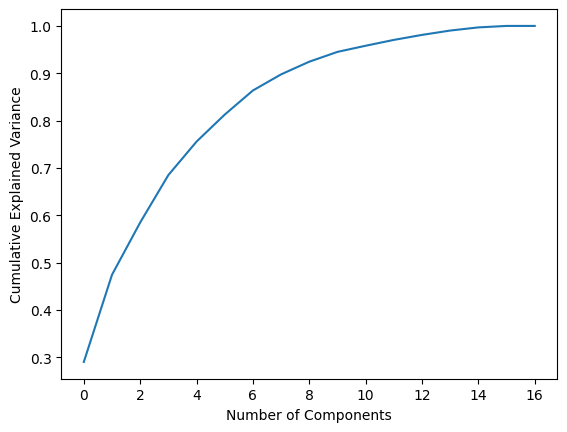

In [25]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')

In [26]:
np.cumsum(pca.explained_variance_ratio_)

array([0.29044997, 0.47452947, 0.58490237, 0.68505818, 0.75571567,
       0.8127604 , 0.86368729, 0.89770753, 0.92447857, 0.94517107,
       0.95813186, 0.97045662, 0.9810481 , 0.99022739, 0.99688251,
       0.9999988 , 1.        ])

The first 6 principal components explain 86.3% of the variation in data

### PCA Summary

The above plot shows us the total explained variance for the number of principal components we use. For our case, we will use 2 principal components. The first 2 principal components expalin 47.5% of the variation in data. While 4 or 5 components would be ideal in terms of explain variance, we pick 2 so that we can visualize the clustering well.

## Perform PCA with 2 principal components with the aim of visualizing clustering.

• Find the 2 columns which give the most covariances.

• Interpret the results of PCA by looking at the covariance matrix (use get_covariance()
method of PCA).

In [27]:
n_components = 2
pca_final = PCA(n_components=n_components)
pca_ccData = pca_final.fit_transform(norm_ccData)

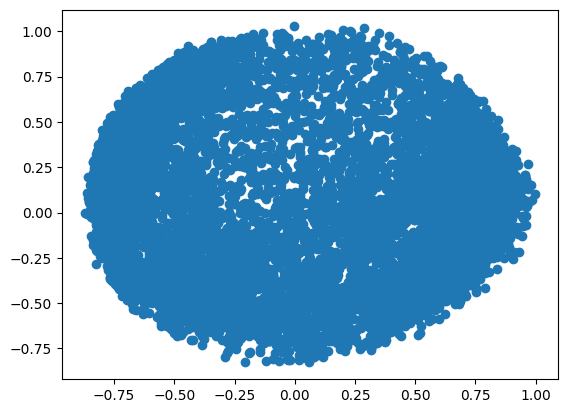

In [28]:
plt.scatter(pca_ccData[:, 0], pca_ccData[:, 1])

The scatter plot is plitted in 2D space with 2 principal components

### Visualize  Reduced Data

When we look at the data, there are no immediate patterns jumping out at us. Next, we try to interpret these principal components.

In [ ]:
n_components = 2
pca_final = PCA(n_components=n_components)
pca_ccData = pca_final.fit_transform(norm_ccData)
for i in np.arange(n_components):
    index = np.argmax(np.absolute(pca_final.get_covariance()[i]))
    max_cov = pca_final.get_covariance()[i][index]
    column = ccData.columns[index]
    print('Principal Component:', i+1, 'Maximum Covariance:', "{:.2f}".format(max_cov), "from column", column)  

np.absolute(pca_final.get_covariance()[0])

Principal Component: 1 Maximum Covariance: 0.06 from column BALANCE
Principal Component: 2 Maximum Covariance: 0.04 from column BALANCE_FREQUENCY


array([0.06459182, 0.01438555, 0.00522135, 0.00645078, 0.00048957,
       0.02398213, 0.0085725 , 0.01009108, 0.01158502, 0.03243225,
       0.02393943, 0.00375408, 0.02170765, 0.01372165, 0.00946624,
       0.00961282, 0.00302147])

### Interpret PCA

Since the principal components are linear combinations of the attributes, we are basically tying to identify which variables affect the principal components the most. More specifically, we look at the covariance matrix to see which attribute has the most covariance with the principal component.

    1. For the first principal component, the BALANCE column has the most covariance. We think of the first principal component as being representative of BALANCE. The BALANCE refers to the balance left in the customer's acount to make purchases.

    2. For the second principal component, the BALANCE_FREQUENCY column has the most covariance. Loosely speaking, the second principal component is representative of the BALANCE_FREQUENCY. The BALANCE_FREQUENCY tells us how often the customer's balance is updated

## Perform K Means Clustering on the 2 component PCA transformed data with clusters ranging from 2 to 11 and plot the K Means inertia against the number of clusters (Elbow Method). 

From the elbow plot, identify the ideal required number of clusters.

### Kmeans Clustering

Recall that in order to use the Kmeans algorithm, we have to provide the number of cluster that we are trying to segment our data into. Since we do not know what is ideal, let us try a range of 2-11 clusters. We will look at metric plots to determine what works best. 

In [30]:
sse = {}
n_clust = np.arange(2,11)

for i in n_clust:
    kmeans = KMeans(n_clusters=i, random_state=0)
    kmeans.fit(pca_ccData)
    sse[i] = kmeans.inertia_

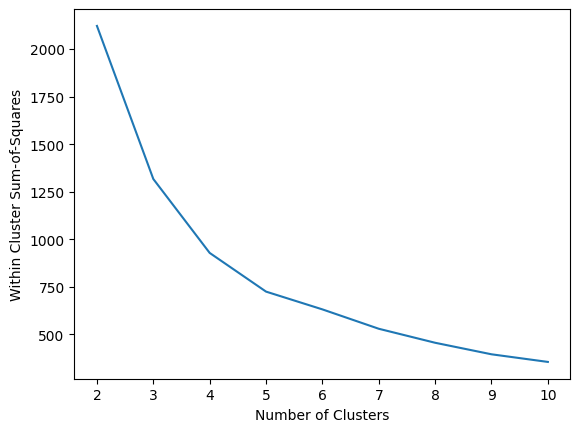

In [31]:
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of Clusters")
plt.ylabel("Within Cluster Sum-of-Squares")
plt.show()

### Summary of Kmeans

In the above plot, we are looking for an "elbow." The elbow tells us the point where incresing the number of variables does not yield a significant decrease in inertia. The inertia here is referring to within cluster sum of squares. It tells how compact a given cluster is. From the above plot, 3 clusters seems sufficient. Although using 10 clusters gives us the least inertia, it will be very difficult to interpret and may not have significant meaning.

• Perform K Means Clustering on the 2 component PCA transformed data with the ideal
number of clusters found in the sixth bullet point.

In [32]:
kmeans = KMeans(n_clusters=3, random_state=0)
kmeans.fit(pca_ccData)

KMeans(n_clusters=3, random_state=0)

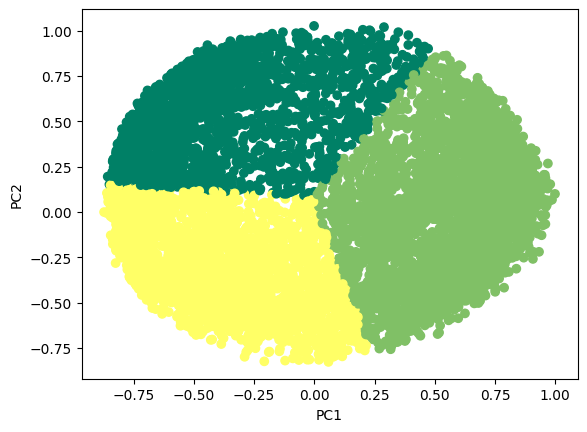

In [33]:
plt.scatter(pca_ccData[:, 0], pca_ccData[:, 1], 
            c=KMeans(n_clusters=3).fit_predict(pca_ccData), cmap= plt.cm.summer)
plt.xlabel("PC1")
plt.ylabel("PC2")   
plt.show()

• Visualize the clusters on a scatter plot between 1st PCA and 2nd PCA component giving
diﬀerent colors to each cluster.

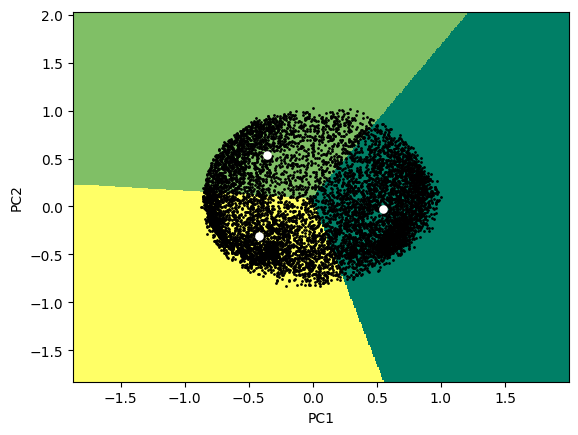

In [34]:
h = .01

x_min, x_max = pca_ccData[:, 0].min() - 1, pca_ccData[:, 0].max() + 1
y_min, y_max = pca_ccData[:, 1].min() - 1, pca_ccData[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

Z= kmeans.predict(np.array(list(zip(xx.ravel(), yy.ravel()))))

Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.summer,
           aspect='auto', origin='lower')

plt.plot(pca_ccData[:, 0], pca_ccData[:, 1], 'k.', markersize=2)
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='o', s=10, linewidths=3,
            color='w', zorder=10)

plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

The Decision boundary is much clearer now, and we also see the center of the 3 identified clusters. Our final objective is to try and make sense of these clusters.

In [35]:
for i in np.arange(len(centroids)):
    print('Center of cluster', i+1, ':', centroids[i])

Center of cluster 1 : [ 0.54693536 -0.02850422]
Center of cluster 2 : [-0.3539088  0.5413186]
Center of cluster 3 : [-0.41823864 -0.31230263]


# Interpretation & Conclusion

When we interpret principle components, they are only "loose" interpretations that give us a general idea of how a principal component behaves with regard to important variables. We cannot equate the attributes with the components, but can only eplain the behavior of the components.

Keep that in mind, let us try to make sense of the three clusters:

    1. Cluster 1(Dark Green): The cluster center lies at (0.54, -0.03). From our interpretation of the principal components, this cluster represents customers whose balances are relatively lower and are updated less frequently

    2. Cluster 2 (Light Green): The cluster center lies at (-0.41, -0.3). This cluster represents customers whose balances are relatively higher and are updated more frequently than the customers in cluster 1

    3. Cluster 3 (Yellow): The cluster center lies at (-0.35, 0.54). This cluster represents customers whose balances are relatively lower - very close to the balances of customers in Cluster 1 - but their balances are updated very frequently. Infact, customers in this cluster have the most frequently updated balances. 